# Generating molecules with a ChEMBL_23 trained autoencoder

In [1]:
import numpy as np
import json
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from model import MoleculeVAE
from utils import encode_smiles, decode_latent_molecule, interpolate, get_unique_mols

# number of dimensions to represent the molecules
# as the model was trained with this number, any operation made with the model must share the dimensions.
latent_dim = 292

# trained_model 0.99 validation accuracy
# trained with 80% of ALL chembl molecules, validated on the other 20.
trained_model = 'chembl_23_model.h5'
charset_file = 'charset.json'

aspirin_smiles = 'CC(=O)Oc1ccccc1C(=O)O'

Using TensorFlow backend.


# Load the model

In [2]:
# load charset and model
with open('charset.json', 'r') as outfile:
    charset = json.load(outfile)

model = MoleculeVAE()
model.load(charset, trained_model, latent_rep_size = latent_dim)

# Encode aspirin SMILES into it's latent representation
- Our aspirin now looks like a 292 dimension continuous array...

In [3]:
aspirin_latent = encode_smiles(aspirin_smiles, model, charset)
aspirin_latent

array([[  9.71856061e-04,  -7.18720779e-02,  -1.07823825e-02,
          7.04334006e-02,   8.07407778e-05,   5.52062728e-02,
         -4.82345792e-03,  -1.46738719e-02,   5.00548892e-02,
         -3.61140221e-02,   4.96174470e-02,   9.41123366e-02,
         -5.76002114e-02,  -2.32497044e-02,  -2.03067763e-03,
          3.01523246e-02,  -9.35144536e-03,  -2.21620724e-02,
          1.16465613e-02,   9.56867486e-02,   5.99888433e-03,
         -1.14213698e-01,   3.02174240e-02,   9.38316062e-02,
          4.03911583e-02,  -4.41120490e-02,   1.50727615e-01,
         -1.07745416e-01,  -1.54005349e-01,  -3.73830693e-03,
         -3.86567339e-02,   3.16653028e-02,   2.70223357e-02,
         -8.04287791e-02,  -2.06629112e-02,  -3.46344523e-02,
         -1.71711408e-02,   9.32422429e-02,   2.97126323e-02,
          6.88279718e-02,  -7.57273361e-02,   1.01418652e-01,
         -6.64200336e-02,  -4.84784693e-02,  -7.68535286e-02,
         -6.34723157e-02,  -6.47386014e-02,  -1.04456255e-02,
        

# Silly check: Are we reconstructing our aspirin properly?
- Looks like we are able to convert aspirin SMILES to a 292 dimension array and go back from it, good!

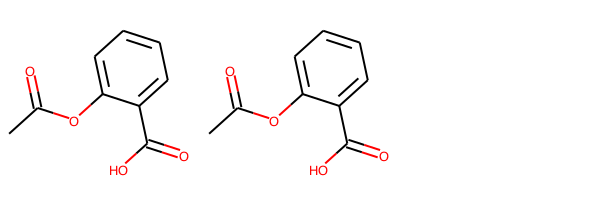

In [4]:
reconstructed_aspirin = decode_latent_molecule(aspirin_latent, model, charset, latent_dim)
original = Chem.MolFromSmiles(aspirin_smiles)
reconstructued = Chem.MolFromSmiles(reconstructed_aspirin)

Draw.MolsToGridImage([original, reconstructued])

# Looking for 1k aspirin neighbours 
- Generating 1k random 292 dimension continuous arrays with mean=aspirin_latent and stdev==0.1 to sample the latent space next to the aspirin. 

In [5]:
stdev = 0.1
latent_mols = stdev * np.random.randn(1000, latent_dim) + aspirin_latent

# Decode the randomly aspirin centered generated latent representations
- We just generated some arrays, we now want molecules!

In [6]:
decoded_molecules = []
for lm in latent_mols:
    decoded_molecules.append(decode_latent_molecule(lm, model, charset, latent_dim))

# Validate the molecules using RDKit
- RDKit is always handful tool to check molecule validity.
- Most of the 1k latent representations won't end in a valid molecule, this is completelly normal due to the complexity of the chemical space. Also notice that this is NOT a perfect autoencoder, it's trained with a validation accuracy of 0.99, so some molecules won't be correctly decoded after the encoding phase.

In [7]:
from rdkit import Chem
from rdkit import RDLogger

# remove warnings and errors from notebook (lots of them due non valid molecule generation)
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

working_mols = []
for smiles in decoded_molecules:
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            working_mols.append(mol)
    except:
        continue

# Let's visualise the aspirinish molecules we artificially generated!

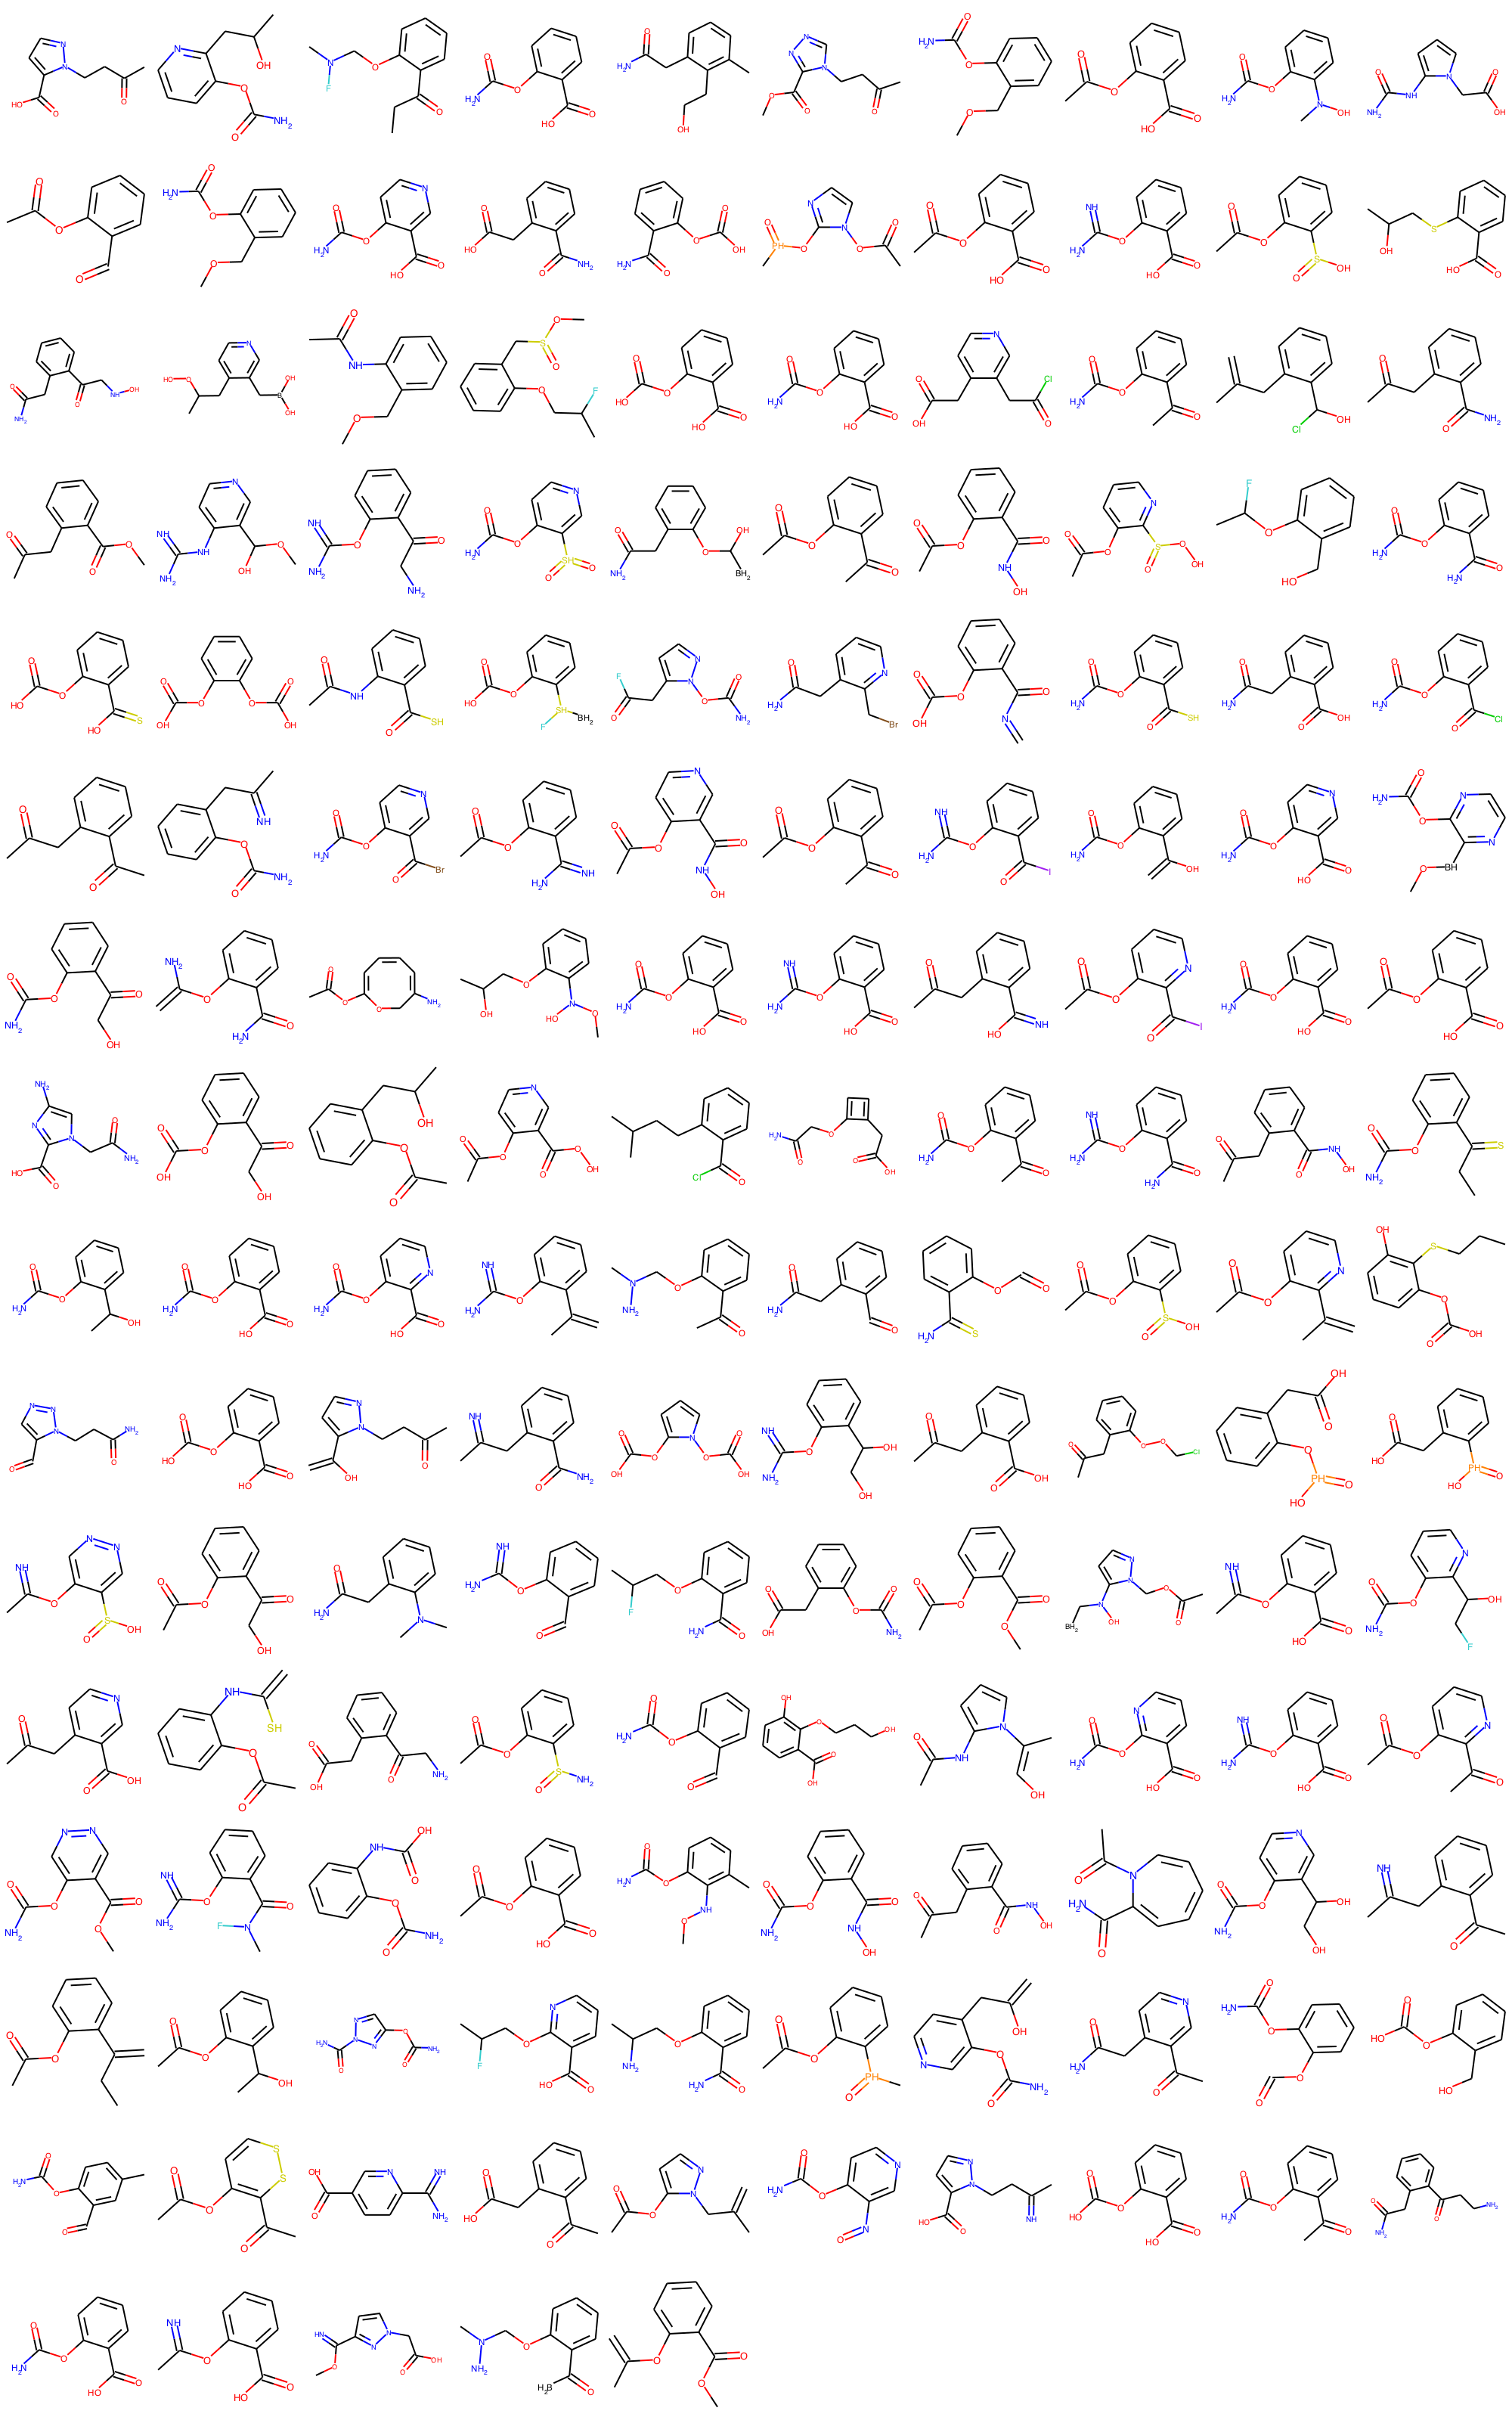

In [8]:
Draw.MolsToGridImage([mol for mol in working_mols], molsPerRow=10)

# Check how many of them we can find using UniChem 
- We managed to generate many unique valid molecules, most of them not existing in ChEMBL. 
- This means that we can sample the model which is representing the ChEMBL chemical space to retrieve molecules that don't exist in the database.

In [9]:
import requests

url = 'https://www.ebi.ac.uk/unichem/rest/inchikey/{}'

unique_mols = get_unique_mols(working_mols)

in_unichem = []
for um in unique_mols:
    res = requests.get(url.format(um[1]))
    if res.status_code == 200:
        in_unichem.append([um[0], res.json()])

not_in_chembl = filter(lambda mol: 1 not in [int(res['src_id']) for res in mol[1]], in_unichem)

print "rdkit valid mols:", len(working_mols)
print "unique molecules:", len(unique_mols)
print "found in unichem:", len(in_unichem)
print "found in unichem and not in chembl:", len(not_in_chembl)

rdkit valid mols: 155
unique molecules: 134
found in unichem: 33
found in unichem and not in chembl: 30


# Show mols found in UniChem and not in ChEMBL

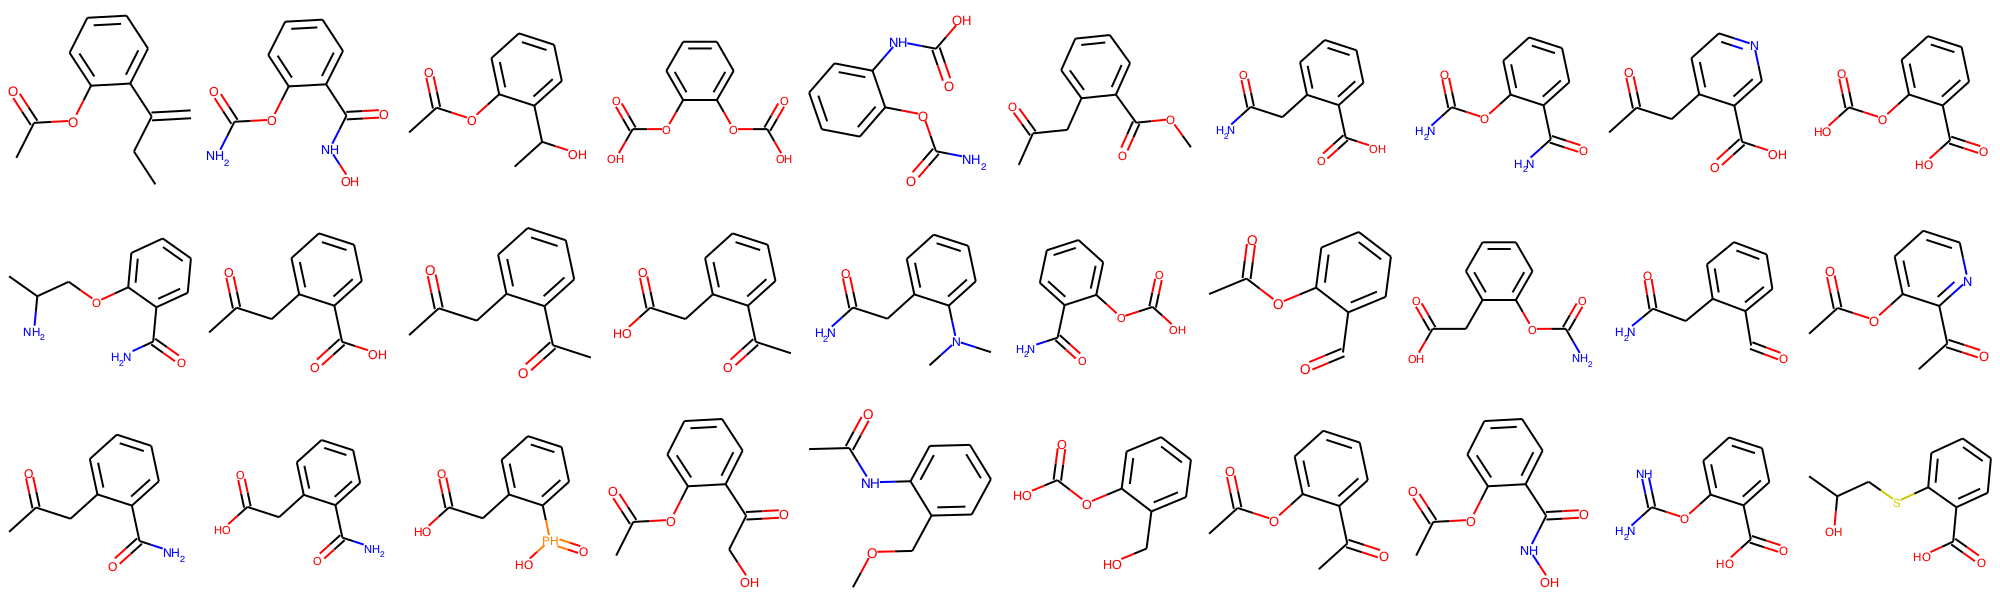

In [10]:
Draw.MolsToGridImage([mol[0] for mol in not_in_chembl], molsPerRow=10)

# Interpolation of two molecules
- Let's make a linear interpolation from paracetamol to celecoxib latent representations and let's check what we got...
- Our results with linear interpolation are not as good as the ones showed in the original paper...

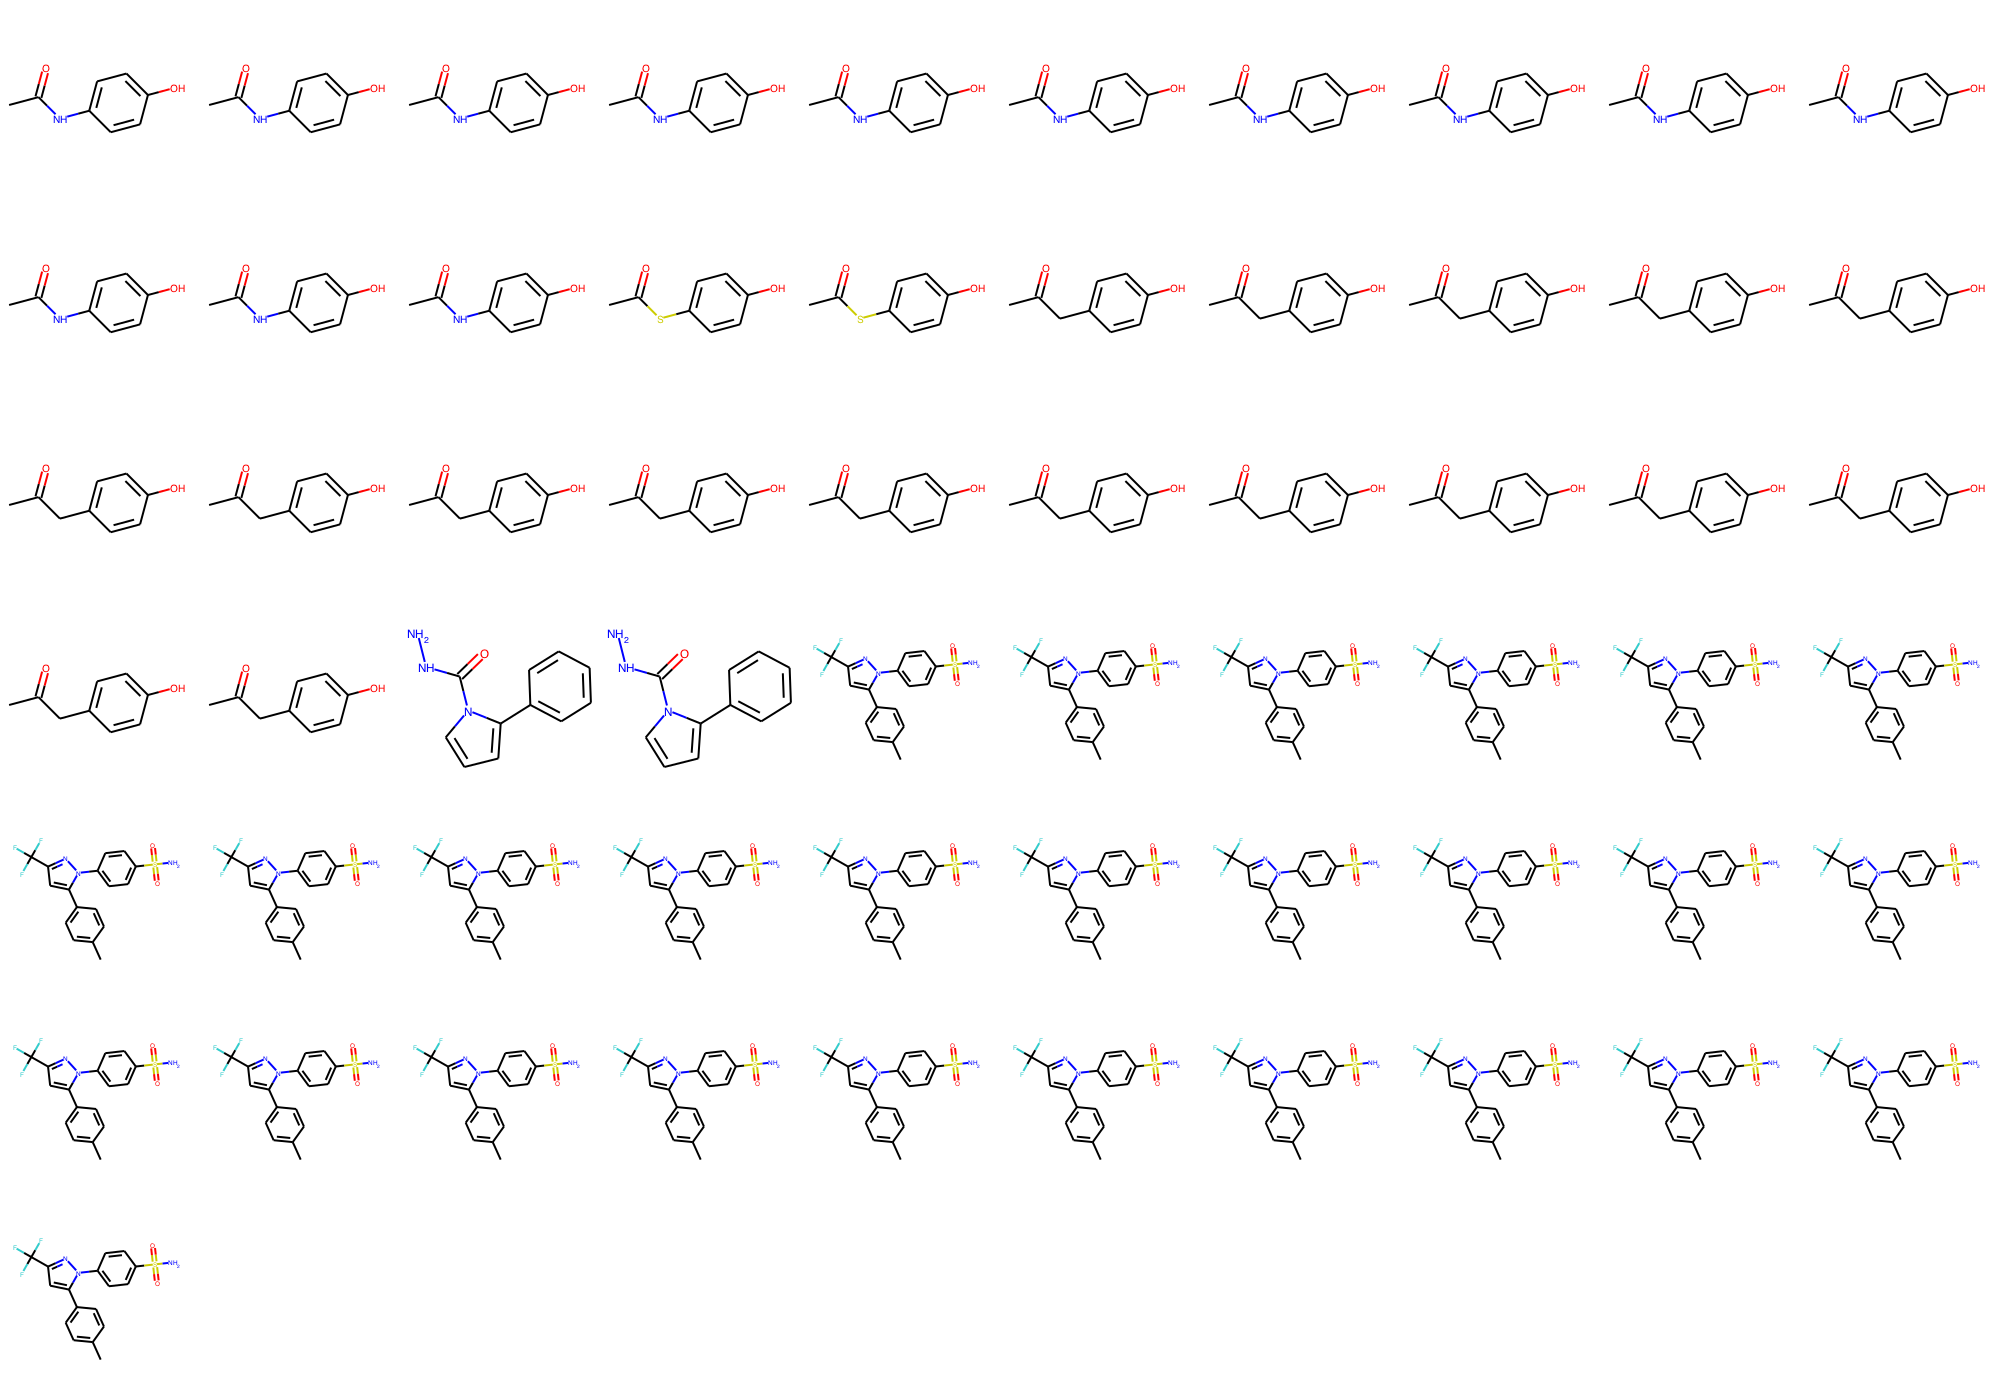

In [11]:
paracetamol_smiles = 'CC(=O)Nc1ccc(O)cc1'
celecoxib_smiles = 'Cc1ccc(cc1)c2cc(nn2c3ccc(cc3)S(=O)(=O)N)C(F)(F)F'

steps = 300
results = interpolate(paracetamol_smiles, celecoxib_smiles, steps, charset, model, latent_dim)
    
working_results = []
for smiles in results:
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            working_results.append(mol)
    except:
        continue
                
Draw.MolsToGridImage(working_results, molsPerRow=10)